In [2]:

import torch
import torch_geometric
from torch_geometric.datasets import TUDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

### Import Dataset

In [3]:
dataset = TUDataset(root='datasets/', name='IMDB-MULTI')
torch.manual_seed(1234)
dataset = dataset.shuffle()

Extracting datasets\IMDB-MULTI\IMDB-MULTI.zip
Processing...
Done!


In [4]:
dataset

IMDB-MULTI(1500)

#### one hot encoding (degree)

In [5]:
max_degree = 0
degs = []
for data in dataset:
    deg = torch_geometric.utils.degree(data.edge_index[1], num_nodes=data.num_nodes)
    degs.extend(deg.numpy())
    max_degree = max(max_degree, max(deg).item())
# assign to one hot degree for each data (OneHotDegree receive maximum degree parameter)
dataset.transform = torch_geometric.transforms.OneHotDegree(int(max_degree))

### Preprocessing

#### Make dataset compatible with networkx, for Louvain algorithm

In [6]:
# edge transform
def edgeToTuple(edge):
    st = []
    for _, (s, d) in enumerate(zip(edge[0], edge[1])):
        st.append((s.item(), d.item()))
    return st

In [7]:
netx_graphs = []
for graph in dataset:
    G = nx.Graph(edgeToTuple(graph.edge_index))
    netx_graphs.append(G)

Sample


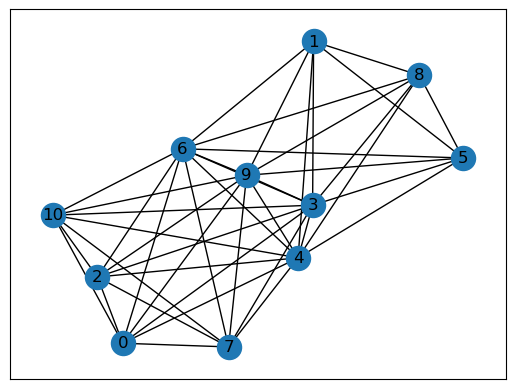

In [8]:
print('Sample')
nx.draw_networkx(netx_graphs[0])

#### Louvain Algorithm - Graph community detection

In [9]:
def makeCommunity(G):
    communities = nx.community.louvain_communities(G, seed=42)
    sub = []
    for c in communities:
        w = G.subgraph(c)
        # print(w.edges)
        sub.append(w.edges)
        # nx.draw_networkx(w, nx.spring_layout(G, seed=6))
    return sub

In [10]:
graph_subs = []
for G in netx_graphs:
    communities = makeCommunity(G)
    edge_from = []
    edge_to = []
    for c in communities:
        for edge in c:
            edge_from.append(edge[0])
            edge_to.append(edge[1])
    graph_subs.append(torch.tensor([edge_from,edge_to]))

In [11]:
graph_oris = []
for g in dataset:
    # print(g.edge_index[1])
    graph_oris.append([g.edge_index[0], g.edge_index[1]])

#### Data Description after preprocessing

1. List of edges, shows relation of pair of nodes ```from``` and ```to```. <br>
```graph_subs (list[tensor()])``` <br>
```graph_oris (list[tensor()])``` 

In [12]:
graph_subs[0][0]

tensor([0, 0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3, 4, 4, 7, 1, 1, 1, 1, 5, 5, 5, 6, 6,
        8])

In [13]:
graphs = []
for _, (ori, sub, target) in enumerate(zip(graph_oris, graph_subs, dataset)):
    # print(target.y)
    graphs.append([ori, sub, target.y])

```graphs[i]``` shows object of one graph <br>
```graphs[i][j]``` features of graph, ```j=0```: original edge index, ```j=1```: louvain subgraph, ```j=2```: graph target class

In [14]:
graphs[1]

[[tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
          3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
          6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8]),
  tensor([1, 2, 3, 4, 5, 6, 7, 8, 0, 2, 3, 4, 5, 6, 7, 8, 0, 1, 3, 4, 5, 6, 7, 8,
          0, 1, 2, 4, 5, 6, 7, 8, 0, 1, 2, 3, 5, 6, 7, 8, 0, 1, 2, 3, 4, 6, 7, 8,
          0, 1, 2, 3, 4, 5, 7, 8, 0, 1, 2, 3, 4, 5, 6, 8, 0, 1, 2, 3, 4, 5, 6, 7])],
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3,
          3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 7],
         [1, 2, 3, 4, 5, 6, 7, 8, 2, 3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 4, 5, 6,
          7, 8, 5, 6, 7, 8, 6, 7, 8, 7, 8, 8]]),
 tensor([2])]

### Train test split

In [15]:
yo = [d.y.item() for d in dataset]
ys = [Data(edge_index=d[1], y=d[2]) for d in graphs]
# yo == ys

In [16]:
subgraph_data = []
for _, (original, subgraph) in enumerate(zip(dataset, graphs)):
    subgraph_data.append(Data(edge_index=subgraph[1], x=original.x, y = original.y, num_nodes= original.num_nodes))

In [17]:
subgraph_data

[Data(x=[11, 89], edge_index=[2, 25], y=[1], num_nodes=11),
 Data(x=[9, 89], edge_index=[2, 36], y=[1], num_nodes=9),
 Data(x=[7, 89], edge_index=[2, 21], y=[1], num_nodes=7),
 Data(x=[12, 89], edge_index=[2, 66], y=[1], num_nodes=12),
 Data(x=[18, 89], edge_index=[2, 32], y=[1], num_nodes=18),
 Data(x=[40, 89], edge_index=[2, 256], y=[1], num_nodes=40),
 Data(x=[8, 89], edge_index=[2, 12], y=[1], num_nodes=8),
 Data(x=[7, 89], edge_index=[2, 21], y=[1], num_nodes=7),
 Data(x=[59, 89], edge_index=[2, 621], y=[1], num_nodes=59),
 Data(x=[13, 89], edge_index=[2, 36], y=[1], num_nodes=13),
 Data(x=[9, 89], edge_index=[2, 36], y=[1], num_nodes=9),
 Data(x=[14, 89], edge_index=[2, 91], y=[1], num_nodes=14),
 Data(x=[10, 89], edge_index=[2, 20], y=[1], num_nodes=10),
 Data(x=[7, 89], edge_index=[2, 21], y=[1], num_nodes=7),
 Data(x=[10, 89], edge_index=[2, 45], y=[1], num_nodes=10),
 Data(x=[17, 89], edge_index=[2, 136], y=[1], num_nodes=17),
 Data(x=[9, 89], edge_index=[2, 16], y=[1], num_n

In [18]:
original_loader = DataLoader(dataset, batch_size=64, shuffle=False)
i = 0
for aa in original_loader:
    print(aa)
    i+=1
    if i == 1:
        break

DataBatch(edge_index=[2, 8508], y=[64], num_nodes=816, x=[816, 89], batch=[816], ptr=[65])


In [19]:
aa

DataBatch(edge_index=[2, 8508], y=[64], num_nodes=816, x=[816, 89], batch=[816], ptr=[65])

In [20]:
subgraph_loader = DataLoader(dataset=subgraph_data, batch_size=64, shuffle=False)
i = 0
for bb in subgraph_loader:
    print(bb)
    i+=1
    if i == 1:
        break

DataBatch(x=[816, 89], edge_index=[2, 3582], y=[64], num_nodes=816, batch=[816], ptr=[65])


In [21]:
bb

DataBatch(x=[816, 89], edge_index=[2, 3582], y=[64], num_nodes=816, batch=[816], ptr=[65])

Train test split

In [22]:
seed = 12345
ratio = 0.8
total = len(dataset)
# subgraph
subgraph_train = subgraph_data[:round(ratio*total)]
subgraph_test = subgraph_data[round(ratio*total):]

# original
original_train = dataset[:round(ratio*total)]
original_test = dataset[round(ratio*total):]

In [23]:
len(subgraph_train) == len(original_train) and len(subgraph_test) == len(original_test) 

True

Create data loader object

In [24]:
batch_size = 32
subgraph_train_loader = DataLoader(subgraph_train, batch_size=batch_size, shuffle=False)
subgraph_test_loader = DataLoader(subgraph_test, batch_size=batch_size, shuffle=False)

original_train_loader = DataLoader(original_train, batch_size=batch_size, shuffle=False)
original_test_loader = DataLoader(original_test, batch_size=batch_size, shuffle=False)

### Create Model

In [25]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear

from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_add_pool

In [101]:
class GraphSubgraphLearning(torch.nn.Module):
    # merging type: o --> complement only, s --> substraction, c --> concatenation
    def __init__(self, dataset, hidden_channels):
        super(GraphSubgraphLearning, self).__init__()
        
        # weight seed
        torch.manual_seed(42)
        self.conv1_o = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2_o = GCNConv(hidden_channels, hidden_channels)
        
        self.conv1_s = GCNConv(dataset.num_node_features, hidden_channels)
        # self.conv1_s = GCNConv(hidden_channels, hidden_channels)
        self.conv2_s = GCNConv(hidden_channels, hidden_channels)
        
        # classification layer
        
        self.lin = Linear(hidden_channels*2, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index_o, edge_index_s, batch_o, batch_s):
        
        # Embed original
        original_embedding = self.conv1_o(x, edge_index_o)
        original_embedding = original_embedding.relu()
        original_embedding = self.conv2_o(original_embedding, edge_index_o)
        original_embedding = original_embedding.relu()
        
        # Embed Subgraph
        subgraph_embedding = self.conv1_s(x, edge_index_s)
        # subgraph_embedding = self.conv1_s(original_embedding, edge_index_s)
        subgraph_embedding = subgraph_embedding.relu()
        subgraph_embedding = self.conv2_s(subgraph_embedding, edge_index_s)
        subgraph_embedding = subgraph_embedding.relu()
        
        original_embedding = global_mean_pool(original_embedding, batch_o)
        subgraph_embedding = global_mean_pool(subgraph_embedding, batch_s)
        h = torch.cat((original_embedding, subgraph_embedding), 1)
        # h = h.relu()
        
        h = self.lin(h)
        h.relu()
        h = self.lin2(h)
        
        return original_embedding, subgraph_embedding, h

In [102]:
model = GraphSubgraphLearning(dataset, 64)
model

GraphSubgraphLearning(
  (conv1_o): GCNConv(89, 64)
  (conv2_o): GCNConv(64, 64)
  (conv1_s): GCNConv(89, 64)
  (conv2_s): GCNConv(64, 64)
  (lin): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=3, bias=True)
)

In [103]:
embed = None
for _, (dt, ds) in enumerate(zip(original_train_loader, subgraph_train_loader)):
    print(dt)
    print(ds.batch)
    embed = model(dt.x, dt.edge_index, ds.edge_index, dt.batch, ds.batch)
    break

DataBatch(edge_index=[2, 5330], y=[32], num_nodes=458, x=[458, 89], batch=[458], ptr=[33])
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
         7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 1

Training

In [104]:
def train(model, original_train_loader, subgraph_train_loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    model.train()
    
    for _, (do, ds) in enumerate(zip(original_train_loader, subgraph_train_loader)):
        _,_, h = model(do.x, do.edge_index, ds.edge_index, do.batch, ds.batch)
        loss = criterion(h, do.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss

@torch.no_grad()
def test(model, original_test_loader, subgraph_test_loader):
    model.eval()
    correct = 0
    for _, (do, ds) in enumerate(zip(original_test_loader, subgraph_test_loader)):
        _,_, h = model(do.x, do.edge_index, ds.edge_index, do.batch, ds.batch)
        pred = h.argmax(dim=1)
        correct += int((pred == do.y).sum())
    return correct/len(original_test_loader.dataset)


In [105]:
len(original_test_loader.dataset)

300

In [106]:
list_train_acc = []
list_test_acc = []
list_loss = []

epoch = 100
for epoch in range(0, epoch):
    loss = train(model, original_train_loader, subgraph_train_loader)
    train_acc = test(model, original_train_loader, subgraph_train_loader)
    test_acc = test(model, original_test_loader, subgraph_test_loader)
    
    list_train_acc.append(round(train_acc, 4))
    list_test_acc.append(round(test_acc, 4))
    list_loss.append(round(loss.item(), 4))

    print(f"epoch: {epoch+1} train_acc: {train_acc:.4f} loss: {loss:.4f} test_acc: {test_acc:.4f}")


epoch: 1 train_acc: 0.4792 loss: 0.9925 test_acc: 0.4467
epoch: 2 train_acc: 0.5242 loss: 0.9819 test_acc: 0.5267
epoch: 3 train_acc: 0.5242 loss: 1.0101 test_acc: 0.5133
epoch: 4 train_acc: 0.5292 loss: 1.0044 test_acc: 0.5167
epoch: 5 train_acc: 0.5392 loss: 1.0293 test_acc: 0.5300
epoch: 6 train_acc: 0.5425 loss: 1.0097 test_acc: 0.5200
epoch: 7 train_acc: 0.5458 loss: 0.9713 test_acc: 0.5267
epoch: 8 train_acc: 0.5075 loss: 1.0058 test_acc: 0.4600
epoch: 9 train_acc: 0.5483 loss: 0.9587 test_acc: 0.5100
epoch: 10 train_acc: 0.5508 loss: 0.9887 test_acc: 0.5400
epoch: 11 train_acc: 0.5517 loss: 1.0319 test_acc: 0.5267
epoch: 12 train_acc: 0.5617 loss: 0.9794 test_acc: 0.5033
epoch: 13 train_acc: 0.5658 loss: 1.0326 test_acc: 0.5133
epoch: 14 train_acc: 0.5700 loss: 0.9929 test_acc: 0.5233
epoch: 15 train_acc: 0.5650 loss: 1.0701 test_acc: 0.5200
epoch: 16 train_acc: 0.5692 loss: 0.9851 test_acc: 0.5167
epoch: 17 train_acc: 0.5642 loss: 1.2718 test_acc: 0.5133
epoch: 18 train_acc: 0.

## Base Model

In [35]:
class Base(torch.nn.Module):
    # merging type: o --> complement only, s --> substraction, c --> concatenation
    def __init__(self, dataset, hidden_channels):
        super(Base, self).__init__()
        
        # weight seed
        torch.manual_seed(42)
        self.conv1_o = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2_o = GCNConv(hidden_channels, hidden_channels)
        # classification layer
        
        self.lin = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index_o, batch_o):
        # Embed original
        original_embedding = self.conv1_o(x, edge_index_o)
        original_embedding = original_embedding.relu()
        original_embedding = self.conv2_o(original_embedding, edge_index_o)
        # subgraph_embedding = subgraph_embedding.relu()
        
        original_embedding = global_mean_pool(original_embedding, batch_o)
        h = self.lin(original_embedding)
        h = h.relu()
        h = self.lin2(h)
        
        return original_embedding, h

In [36]:
base = Base(dataset, 64)

In [37]:
base

Base(
  (conv1_o): GCNConv(89, 64)
  (conv2_o): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=3, bias=True)
)

In [38]:
def train_base(model, original_train_loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    model.train()
    
    for do in original_train_loader:
        _, h = model(do.x, do.edge_index, do.batch)
        loss = criterion(h, do.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss

@torch.no_grad()
def test_base(model, original_test_loader):
    model.eval()
    correct = 0
    for do in original_test_loader:
        _, h = model(do.x, do.edge_index, do.batch)
        pred = h.argmax(dim=1)
        correct += int((pred == do.y).sum())
    return correct/len(original_test_loader.dataset)


In [39]:
list_train_acc = []
list_test_acc = []
list_loss = []

epoch = 50
for epoch in range(0, epoch):
    loss = train_base(base, original_train_loader)
    train_acc = test_base(base, original_train_loader)
    test_acc = test_base(base, original_test_loader)
    
    list_train_acc.append(round(train_acc, 4))
    list_test_acc.append(round(test_acc, 4))
    list_loss.append(round(loss.item(), 4))

    print(f"epoch: {epoch+1} train_acc: {train_acc:.4f} loss: {loss:.4f} test_acc: {test_acc:.4f}")


epoch: 1 train_acc: 0.4533 loss: 1.0671 test_acc: 0.4733
epoch: 2 train_acc: 0.4767 loss: 1.0341 test_acc: 0.4433
epoch: 3 train_acc: 0.5208 loss: 1.0559 test_acc: 0.5233
epoch: 4 train_acc: 0.5175 loss: 1.1015 test_acc: 0.5233
epoch: 5 train_acc: 0.5208 loss: 1.1019 test_acc: 0.4967
epoch: 6 train_acc: 0.5292 loss: 1.1420 test_acc: 0.5167
epoch: 7 train_acc: 0.5233 loss: 1.2109 test_acc: 0.5133
epoch: 8 train_acc: 0.5367 loss: 1.2201 test_acc: 0.5167
epoch: 9 train_acc: 0.5283 loss: 1.3156 test_acc: 0.5000
epoch: 10 train_acc: 0.5325 loss: 1.2796 test_acc: 0.5067
epoch: 11 train_acc: 0.5300 loss: 1.3752 test_acc: 0.4867
epoch: 12 train_acc: 0.5367 loss: 2.1771 test_acc: 0.5033
epoch: 13 train_acc: 0.5442 loss: 1.4365 test_acc: 0.5267
epoch: 14 train_acc: 0.5300 loss: 2.9663 test_acc: 0.4900
epoch: 15 train_acc: 0.5467 loss: 2.4333 test_acc: 0.5067
epoch: 16 train_acc: 0.5367 loss: 2.4776 test_acc: 0.4833
epoch: 17 train_acc: 0.5400 loss: 2.4929 test_acc: 0.5033
epoch: 18 train_acc: 0.